In [4]:
from __future__ import division, print_function

import os
import sys
import numpy as np
import scipy
import pandas as pd
import itertools

from seaborn import heatmap
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12,6)

%load_ext autoreload
%autoreload 2

def price(x, a=200, b=10, d=10, t=np.linspace(1,10,10)):
    """ Returns the price given a demand x and time t
    See equation 4 above"""

    return (a - b * x) * d / (d + t)

def demand(p, a=200, b=10, d=10, t=np.linspace(1,10,10)):
    """ Return demand given an array of prices p for times t
    (see equation 5 above)"""

    return  1.0 / b  * ( a - p * ( d + t ) / d )

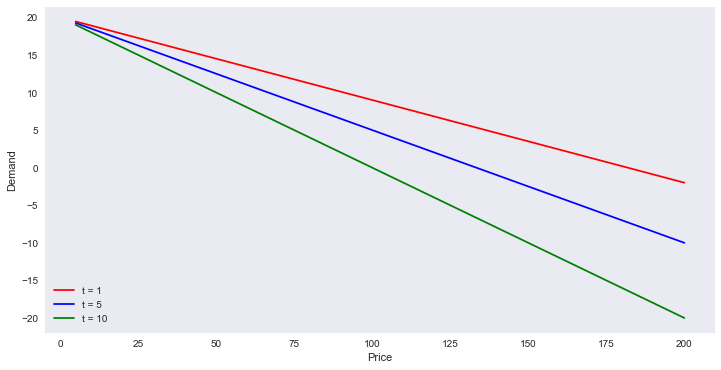

In [5]:
price_vals = np.array([5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 100.0, 200.0])
t_vals = np.array([1, 5, 10])
colors = ['red', 'blue', 'green']

for time, color in zip(t_vals, colors) :
    plt.plot(price_vals, demand(price_vals, t=time), color=color, label='t = {}'.format(time))
    
plt.legend(loc=3)
plt.xlabel("Price")
plt.ylabel('Demand')
plt.grid(False)
plt.show()

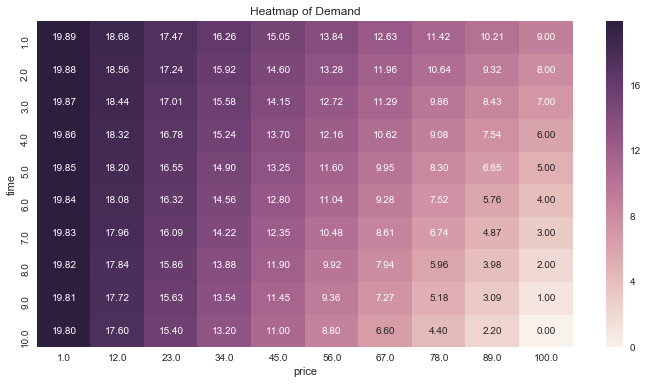

In [6]:
t_vals = np.linspace(1,10,10)
p_vals = np.linspace(1,100,10)
tmp = list(itertools.product(t_vals,p_vals))
rev_df = pd.DataFrame(tmp, columns=['time','price'])
rev_df['demand'] = rev_df.apply(lambda row : demand(row['price'], t=row['time']), axis=1)
rev_df['revenue'] = rev_df.apply(lambda row : row['price']*row['demand'], axis=1)
rev_df_demand = rev_df.pivot('time','price',values='demand')
heatmap(rev_df_demand, annot=True, fmt=".2f")
plt.title('Heatmap of Demand')

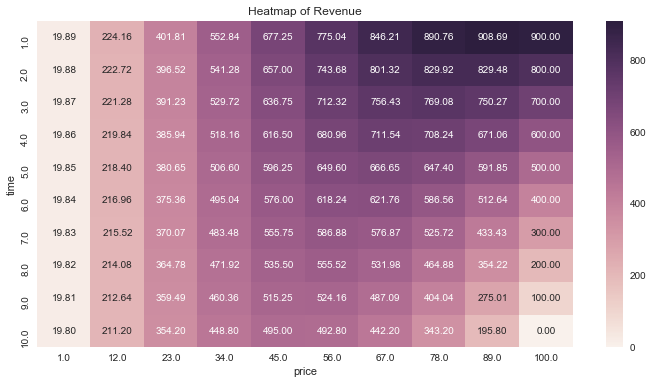

In [7]:
rev_df_revenue = rev_df.pivot('time','price',values='revenue')
heatmap(rev_df_revenue, annot=True, fmt=".2f")
plt.title('Heatmap of Revenue')

In [8]:
def objective(x_t, a=200, b=10, d=10, t=np.linspace(1,10,10)):
    """ Objective function takes a vector of demand x_t and
    returns the sum of demand x price for the time period
    of interest.

    We multiply by -1.0 as the optimization routine we will
    use *minimizes* the objective function.
    """
    return -1.0 * np.sum( x_t * price(x_t, a=a, b=b, d=d, t=t) )

def constraint_1(x_t, s_0=150):
    """ Inventory constraint. s_0 - np.sum(x_t) >= 0.
    This is an inequality constraint. See more below.
    """
    return s_0 - np.sum(x_t)

def constraint_2(x_t):
    """ Positive demand. Another inequality constraint x_t >= 0 """
    return x_t

def constraint_3(x_t, a=200, b=10):
    """ Maximum demand. Another inequality constraint """
    return (a / b) - x_t

In [13]:
import scipy.optimize as optimize

# Model parameters :
s_0 = 150.0
a = 200.0
b = 10.0
d = 10.0
t = np.linspace(1,10,10)

# Starting values :
x_start = 3.0 * np.ones(len(t))

# bounds on the values :
bounds = tuple((0,20.0) for x in x_start)

# Constraints :
constraints = ({'type': 'ineq', 'fun':  lambda x, s_0=s_0:  constraint_1(x,s_0=s_0)},
        {'type': 'ineq', 'fun':  lambda x: constraint_2(x)},
        {'type': 'ineq', 'fun': lambda x, a=a, b=b: constraint_3(x, a=a, b=b)})

In [14]:
opt_results = optimize.minimize(objective, x_start, args=(a, b, d, t),
                            method='SLSQP', bounds=bounds,  constraints=constraints)
print(opt_results)

     fun: -6687.714030531401
     jac: array([-0.00073242, -0.00195312,  0.00280762, -0.00494385,  0.00384521,
       -0.00036621,  0.00115967, -0.00213623, -0.00024414,  0.00097656])
 message: 'Optimization terminated successfully.'
    nfev: 157
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([  9.99996057,   9.99989841,  10.00011689,   9.99989972,
        10.0000114 ,  10.00007382,  10.00013996,   9.99964962,
        10.00000733,  10.00015055])


In [15]:
np.sum(opt_results['x'])

99.999908280842689

In [16]:
print( price(opt_results['x'], a=a, b=b, d=d, t=t) )

[ 90.90944936  83.33417991  76.92217774  71.42928768  66.66659067
  62.49953862  58.82270611  55.55750212  52.63154039  49.99924723]
